# Homework Assignment 1 - Evan Callaghan

## Topics: Data exploration, discovering general trends, building initial models to predict fraud

In [1]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, precision_recall_curve

## Defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'data-448-bucket-callaghan'
bucket = s3.Bucket(bucket_name)

## 1. Created new s3 bucket: data-448-bucket-callaghan
## Using pandas to read the data files

file_key = 'train.csv'
file_key2 = 'test.csv'

bucket_object = bucket.Object(file_key)
bucket_object2 = bucket.Object(file_key2)

file_object = bucket_object.get()
file_object2 = bucket_object2.get()

file_content_stream = file_object.get('Body')
file_content_stream2 = file_object2.get('Body')

train = pd.read_csv(file_content_stream, sep = '|')
test = pd.read_csv(file_content_stream2, sep = '|')

train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [2]:
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


In [3]:
## 2. Reporting the number of observations in the train and test data-frames

print("Train dimensions:", train.shape)
print("Test dimensions:", test.shape)

## Creating a frequency table of the target variable (fraud)
print('\nNumber of fraud in training set:\n', train['fraud'].value_counts())

## Relative frequencies
print('\nRelative proportion of fraud in training set:\n', train['fraud'].value_counts() / train.shape[0])

Train dimensions: (1879, 10)
Test dimensions: (498121, 9)

Number of fraud in training set:
 0    1775
1     104
Name: fraud, dtype: int64

Relative proportion of fraud in training set:
 0    0.944651
1    0.055349
Name: fraud, dtype: float64


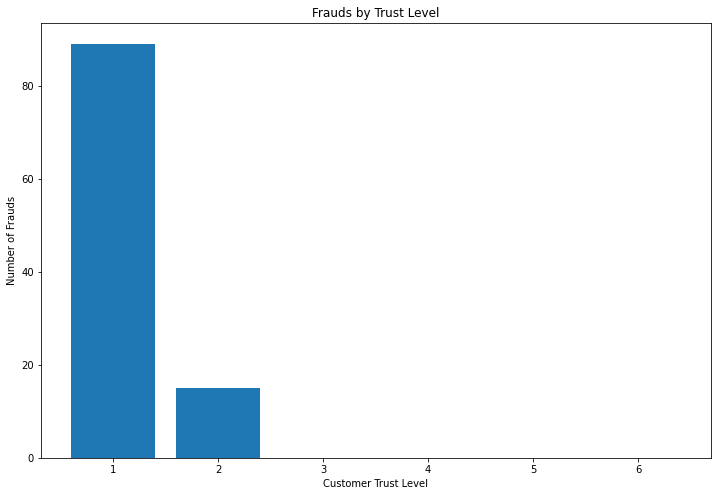

In [4]:
## 3. a) Visualization 1 -- Bar plot of total number of frauds for each "Trust Level" group

trust = train.groupby('trustLevel').sum()

fig = plt.figure(figsize = (12,8))
plt.bar(trust.index, trust['fraud'])
plt.title('Frauds by Trust Level')
plt.xlabel('Customer Trust Level')
plt.ylabel('Number of Frauds')
plt.show()

## Clearly, we can see that the higher customer trust scores have no fraud transactions. All frauds
## are made up of customers with a trust score of 1 or 2. This seems to be an important variable for
## fraud detection.

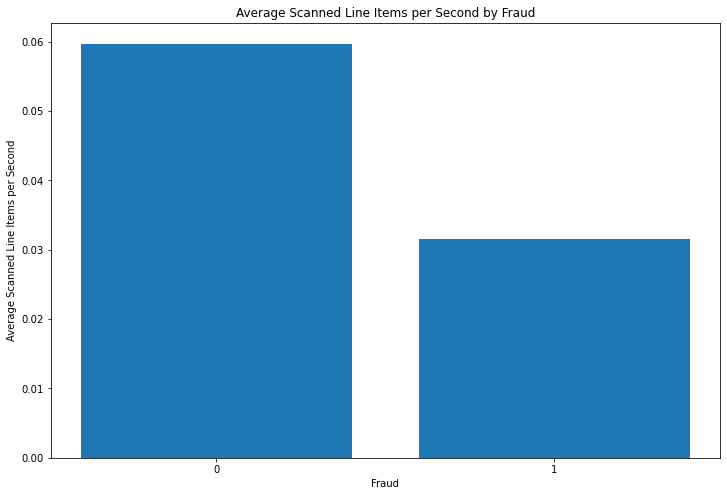

In [5]:
## 3. b) Visualization 2 -- Bar plot of average number of scanned products between fraud and 
## not fraud transactions

train['fraud_label'] = np.where(train['fraud'] == 0, '0', '1')

average = train.groupby('fraud_label').mean()

train = train.drop(columns = 'fraud_label')

fig = plt.figure(figsize = (12,8))
plt.bar(average.index, average['scannedLineItemsPerSecond'])
plt.title('Average Scanned Line Items per Second by Fraud')
plt.xlabel('Fraud')
plt.ylabel('Average Scanned Line Items per Second')
plt.show()

## Here, we can see that for fraud transactions, the average number of scanned items per second is about 
## 50% less than the average number of scanned items per second for non-fraud transactions. This seems to 
## be an important variable for fraud detection. Clearly, the customers committing fraud are, on average, 
## scanning less items per second. 

In [6]:
## 4. Building and comparing the performance of two different models

## Extracting variable importance scores

## Defining the empty data frame to store results
importance = pd.DataFrame(columns = train.columns).drop(columns = ['fraud'])

## Repeating 100 times
for i in range(0, 100):

    ## Defining the input and target variables
    X = train.drop(columns = ['fraud'])
    Y = train['fraud']

    ## Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    ## Building the model
    rf_md = RandomForestClassifier(n_estimators = 500, max_depth = 5).fit(X_train, Y_train)

    ## Extracting the feature importance scores
    importance.loc[i] = rf_md.feature_importances_.T

    
## Computing the average importance of each of the variables across the 100 splits
pd.DataFrame({'Variable':importance.mean().index, 
              'Importance_Score':importance.mean().values}).sort_values(by = 'Importance_Score', 
                                                                        ascending = False).reset_index(drop = True)

,Variable,Importance_Score
0,trustLevel,0.378295
1,scannedLineItemsPerSecond,0.154355
2,totalScanTimeInSeconds,0.136356
3,lineItemVoidsPerPosition,0.100292
4,valuePerSecond,0.078333
5,lineItemVoids,0.056210
6,grandTotal,0.048870
7,scansWithoutRegistration,0.037988
8,quantityModifications,0.009300


In [7]:
## 4. a) Subsetting the data with the five most important variables

## Defining input and target variables
X = train[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
Y = train['fraud']

## Splitting the data (keeping proportions of 0's and 1's the same)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

In [8]:
## 4. a) Model #1 - Random Forest Classifier

## Building the model
md1 = RandomForestClassifier(n_estimators = 500, max_depth = 5).fit(X_train, Y_train)
    
## Predicting on the test set
md1_preds = md1.predict_proba(X_test)[:, 1]

## Computing the precision-recall curve to estimate the optimal cut-off value
precision, recall, cutoff = precision_recall_curve(Y_test, md1_preds)

## Creating the data frame to store values
rf_cutoff = pd.DataFrame({'Precision': precision[:-1], 'Recall': recall[:-1], 'Cutoff': cutoff})

## Using the distance formula to find the optimal cutoff (precision = 1.0, recall = 1.0)
rf_cutoff['Recall_minus_1'] = rf_cutoff['Recall'] - 1
rf_cutoff['Precision_minus_1'] = rf_cutoff['Precision'] - 1

rf_cutoff['Distance'] = np.sqrt(rf_cutoff['Recall_minus_1']**2 + rf_cutoff['Precision_minus_1']**2)

## Sorting the data frame and extracting the threshold value with the minimal distance
rf_cutoff = rf_cutoff.sort_values(by = 'Distance', ascending = True).reset_index(drop = True)

## Extracting optimal cutoff
rf_cutoff_val = rf_cutoff['Cutoff'][0]
print('Optimal Cut-off Value:', rf_cutoff_val, '\n')

## Changing likelihoods to labels with new cutoff value
md1_preds_label = np.where(md1_preds < rf_cutoff_val, 0, 1)

## Printing the classification report
print(classification_report(Y_test, md1_preds_label))

Optimal Cut-off Value: 0.3597501964054317 

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       355
           1       0.88      0.71      0.79        21

    accuracy                           0.98       376
   macro avg       0.93      0.85      0.89       376
weighted avg       0.98      0.98      0.98       376



     Recall  Precision   Cutoff
0  0.714286   0.882353  0.35975


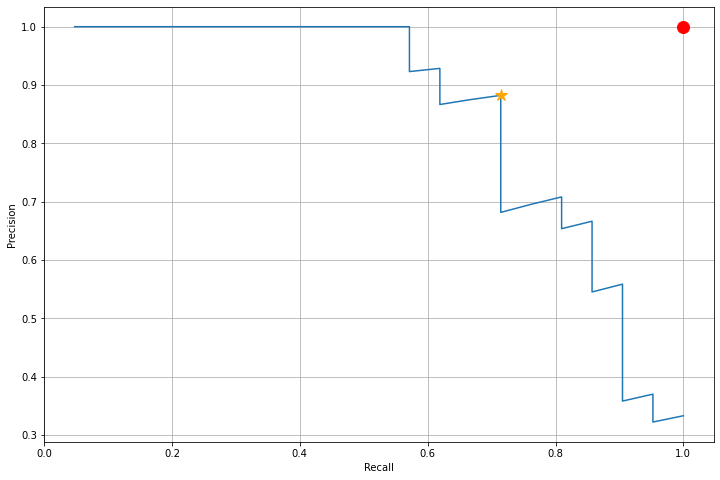

In [10]:
## Visualizing the precision-recall curve for Model #1

## Printing the optimal recall, precision, cutoff
print(rf_cutoff[['Recall', 'Precision', 'Cutoff']][0:1])

plt.figure(figsize= (12,8))
plt.plot(recall[:-1], precision[:-1])
plt.plot([1], 1, 'o', color = 'Red', markersize = 12)
plt.plot([rf_cutoff['Recall'][0]], rf_cutoff['Precision'][0], '*', color = 'Orange', markersize = 12)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

In [13]:
## 4. b) Model #2 - AdaBoost Classifier

## Building the model
md2 = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5), n_estimators = 500,
                        learning_rate = 0.01).fit(X_train, Y_train)

## Predicting on the test set
md2_preds = md2.predict_proba(X_test)[:, 1]

## Computing the precision-recall curve to estimate the optimal cut-off value
precision, recall, cutoff = precision_recall_curve(Y_test, md2_preds)

## Creating the data frame to store values
ada_cutoff = pd.DataFrame({'Precision': precision[:-1], 'Recall': recall[:-1], 'Cutoff': cutoff})

## Using the distance formula to find the optimal cutoff
ada_cutoff['Recall_minus_1'] = ada_cutoff['Recall'] - 1
ada_cutoff['Precision_minus_1'] = ada_cutoff['Precision'] - 1

ada_cutoff['Distance'] = np.sqrt(ada_cutoff['Recall_minus_1']**2 + ada_cutoff['Precision_minus_1']**2)

## Sorting the data frame and extracting the threshold value with the minimal distance
ada_cutoff = ada_cutoff.sort_values(by = 'Distance', ascending = True).reset_index(drop = True)

## Extracting optimal cutoff
ada_cutoff_val = ada_cutoff['Cutoff'][0]
print('Optimal Cut-off Value:', ada_cutoff_val, '\n')

## Changing likelihoods to labels with new cutoff value
md2_preds_label = np.where(md2_preds < ada_cutoff_val, 0, 1)

## Printing the classification report
print(classification_report(Y_test, md2_preds_label))

Optimal Cut-off Value: 0.023526711848395342 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       355
           1       0.84      0.76      0.80        21

    accuracy                           0.98       376
   macro avg       0.91      0.88      0.89       376
weighted avg       0.98      0.98      0.98       376



     Recall  Precision    Cutoff
0  0.761905   0.842105  0.023527


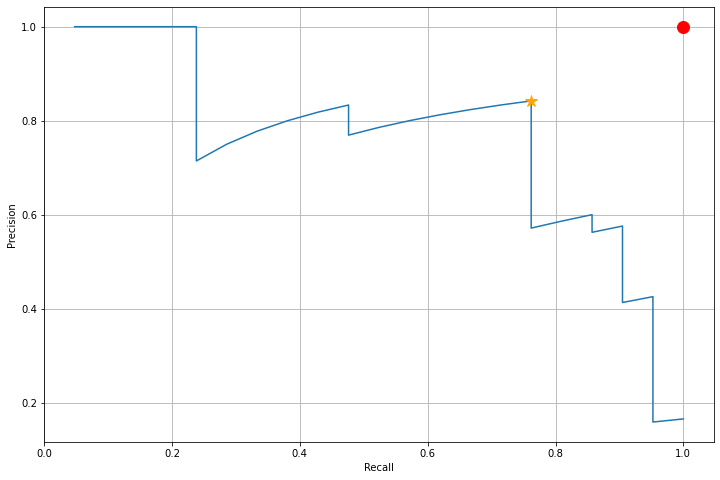

In [16]:
## Visualizing the precision-recall curve for Model #2

## Printing the optimal recall, precision, cutoff
print(ada_cutoff[['Recall', 'Precision', 'Cutoff']][0:1])

plt.figure(figsize= (12,8))
plt.plot(recall[:-1], precision[:-1])
plt.plot([1], 1, 'o', color = 'Red', markersize = 12)
plt.plot([ada_cutoff['Recall'][0]], ada_cutoff['Precision'][0], '*', color = 'Orange', markersize = 12)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

In [ ]:
## Using the results from part (b) and (c), we would use the AdaBoost Classifier model to predict customer fraud.
## Since we are classifying frauds, it is important to have a high recall score. The AdaBoost model has a slightly 
## higher recall score (ability to classify the minority class), and therefore we would select this model despite
## a slightly lower precision score. 